In [2]:
import pandas as pd 
df = pd.read_csv("../data/clean_listings.csv")
df.head()

,location,property_type,bedrooms,bathrooms,size_sqm,amenities,price_kes,listing_date,source,amenity_score,price_per_sqm,month
0,Kilimani,Apartment,2,2,95,parking|security|gym,12500000,NaN,https://example.com/1,3,131578.947368,NaN
1,Westlands,Apartment,3,3,140,parking|security|gym|pool,18500000,NaN,https://example.com/2,4,132142.857143,NaN
2,Ruaka,Apartment,2,2,85,parking|security,8900000,NaN,https://example.com/3,2,104705.882353,NaN
3,Karen,Maisonette,4,4,320,garden|parking|security,45000000,NaN,https://example.com/4,3,140625.000000,NaN
4,Runda,Bungalow,5,5,500,garden|pool|parking|security,85000000,NaN,https://example.com/5,4,170000.000000,NaN


In [3]:
print("Shape:", df.shape)
df.isna().sum()


Shape: (44, 12)


location          0
property_type     0
bedrooms          0
bathrooms         0
size_sqm          0
amenities         0
price_kes         0
listing_date     44
source            0
amenity_score     0
price_per_sqm     0
month            44
dtype: int64

In [4]:
top_locations = (
    df.groupby("location")["price_kes"]
      .median()
      .sort_values(ascending=False)
)

top_locations.head(10)

location
Nyari            110000000.0
Gigiri            95000000.0
Karen             85000000.0
Runda             85000000.0
Muthaiga          72000000.0
Ridgeways         68000000.0
Spring Valley     52000000.0
Lavington         39000000.0
Buruburu          22000000.0
Parklands         21000000.0
Name: price_kes, dtype: float64

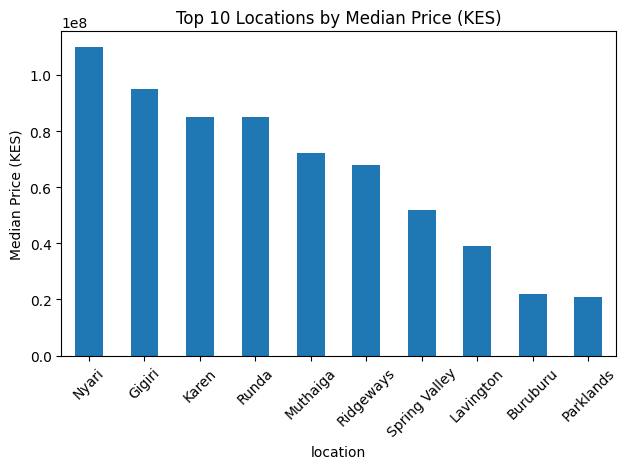

In [5]:
import matplotlib.pyplot as plt

top_locations.head(10).plot(kind="bar")
plt.title("Top 10 Locations by Median Price (KES)")
plt.ylabel("Median Price (KES)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
df[["size_sqm", "price_kes"]].corr()


,size_sqm,price_kes
size_sqm,1.000000,0.983766
price_kes,0.983766,1.000000


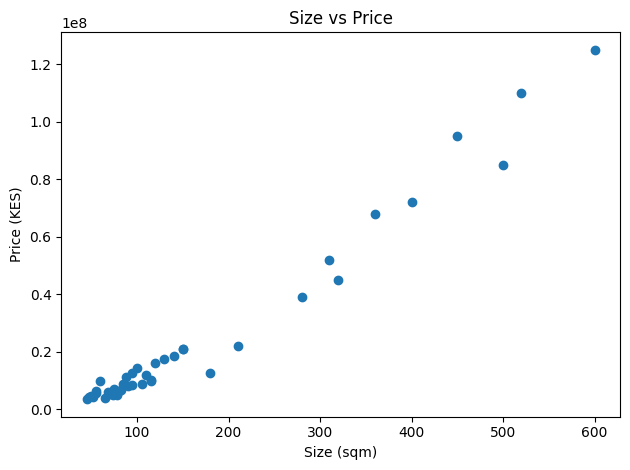

In [7]:
plt.scatter(df["size_sqm"], df["price_kes"])
plt.xlabel("Size (sqm)")
plt.ylabel("Price (KES)")
plt.title("Size vs Price")
plt.tight_layout()
plt.show()


In [9]:
# which amenities increase value?? 
common_amenities = ["parking", "security", "gym", "pool", "garden"]

for a in common_amenities:
    has_a = df["amenities"].str.contains(a, na=False)
    median_yes = df.loc[has_a, "price_kes"].median()
    median_no  = df.loc[~has_a, "price_kes"].median()
    print(f"{a:8} | with: {median_yes:,.0f} | without: {median_no:,.0f}")


parking  | with: 11,500,000 | without: 4,250,000
security | with: 10,700,000 | without: 5,300,000
gym      | with: 15,250,000 | without: 7,700,000
pool     | with: 52,000,000 | without: 8,200,000
garden   | with: 68,000,000 | without: 7,200,000


In [10]:
# Baseline Model - Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

features = ["location", "property_type", "bedrooms", "bathrooms", "size_sqm", "amenity_score"]
target = "price_kes"

df_model = df.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["location", "property_type"]),
        ("num", "passthrough", ["bedrooms", "bathrooms", "size_sqm", "amenity_score"]),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

mae, rmse, r2


(5102953.965455002, np.float64(7869478.259588036), 0.955350692965071)

In [11]:
print(f"On average, our predictions are off by about {mae:,.0f} KES.")


On average, our predictions are off by about 5,102,954 KES.
